In [1]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# technical analysis
import ta

# Pyfolio
import pyfolio as pf

C:\Users\JHCho\anaconda3\envs\py37\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


## data: 5 minutes data

In [2]:
df_ = pd.read_csv('C:ethusd5min.csv')
df = df_.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2020-04-10 00:00:00,169.56,169.72,169.41,169.43,2906.41820,1586477099999,4.930542e+05,707,2260.79119,3.835677e+05,0
2020-04-10 00:05:00,169.44,169.59,168.92,169.22,3376.45186,1586477399999,5.711061e+05,1004,1951.63764,3.301054e+05,0
2020-04-10 00:10:00,169.23,169.42,168.70,168.78,3007.20677,1586477699999,5.081008e+05,752,929.71120,1.571687e+05,0
2020-04-10 00:15:00,168.84,169.12,168.80,169.00,1465.81110,1586477999999,2.476386e+05,472,637.17163,1.076405e+05,0
2020-04-10 00:20:00,168.99,169.40,168.96,169.36,1067.16710,1586478299999,1.806507e+05,418,343.42918,5.811992e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-09 23:40:00,2066.80,2069.36,2065.89,2067.74,696.35201,1618011899999,1.439804e+06,1078,350.52749,7.246912e+05,0
2021-04-09 23:45:00,2067.75,2070.85,2067.62,2070.42,1039.88778,1618012199999,2.152313e+06,1344,554.96546,1.148618e+06,0
2021-04-09 23:50:00,2070.42,2070.95,2069.05,2069.52,773.88383,1618012499999,1.601904e+06,1142,428.07969,8.860856e+05,0


In [3]:
close = pd.to_numeric(df.close)

## Bollinger Band Strategy


In [4]:
window = 30

bbh = ta.volatility.bollinger_hband(close,window)
bbl = ta.volatility.bollinger_lband(close,window)

In [5]:
long_ind = close.loc[(np.sign(close-bbl).diff() == 2)].index
short_ind = close.loc[(np.sign(close-bbh).diff() == -2)].index

longs = pd.Series(1, index=long_ind)
shorts = pd.Series(-1, index=short_ind)

In [6]:
signals = pd.concat([longs,shorts]).sort_index()

In [7]:
signals

timestamp
2020-04-10 02:45:00    1
2020-04-10 04:10:00    1
2020-04-10 07:05:00    1
2020-04-10 07:20:00    1
2020-04-10 07:35:00    1
                      ..
2021-04-09 15:40:00    1
2021-04-09 16:10:00    1
2021-04-09 19:05:00   -1
2021-04-09 21:00:00    1
2021-04-09 23:15:00    1
Length: 5500, dtype: int64

In [8]:
signals = signals.diff().dropna()*.5 # drop when same signal follows
signals = signals.loc[signals!=0]

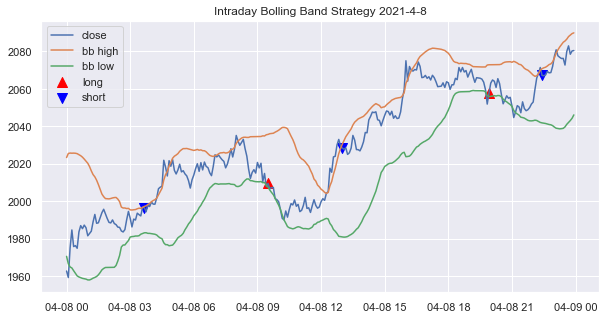

In [9]:
# Intraday
sc = signals
title =  'Intraday Bolling Band Strategy'

long = close.loc[signals.loc[signals==1].index]
short = close.loc[signals.loc[signals==-1].index]

day = ' 2021-4-8'
s = 100

plt.figure(figsize=(10,5))
plt.plot(close.loc[day])
plt.plot(bbh.loc[day])
plt.plot(bbl.loc[day])
plt.scatter(long.loc[day].index, long.loc[day],s=s, c='red',marker='^', alpha=1)
plt.scatter(short.loc[day].index, short.loc[day],s=s, c='blue',marker='v', alpha=1)
plt.legend(['close','bb high','bb low','long','short'])
plt.title(title + day)
plt.show()

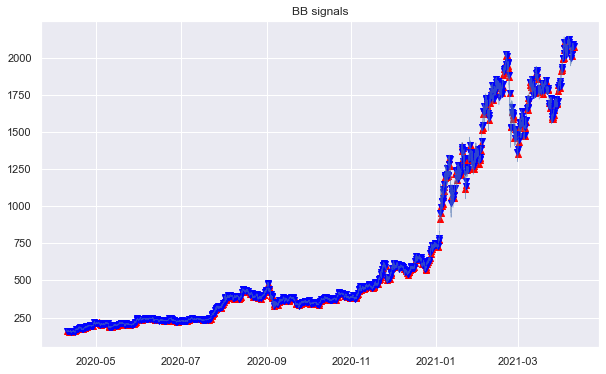

In [10]:
sc = signals
title =  'BB signals'

plt.figure(figsize=(10,6))
plt.plot(close, linewidth=0.5,alpha=0.6)
plt.scatter(long.index, long, c='red',marker='^', alpha=1)
plt.scatter(short.index, short, c='blue',marker='v', alpha=1)

plt.title(title)
plt.show()

## Backtest
Trading
- Only long  position
- Enter the long position when the long signal comes, exit the position when the short signal comes.
- Ignore when long or short signal comes in a row.

In [11]:
mult = (signals+1)/2
rets = (close.loc[signals.index].pct_change().shift(-1))*mult
rets = rets.loc[rets!=0].dropna()

In [12]:
rets

timestamp
2020-04-10 13:25:00   -0.002028
2020-04-10 22:50:00    0.020182
2020-04-11 07:35:00   -0.012808
2020-04-11 20:20:00    0.016709
2020-04-12 02:15:00    0.002551
                         ...   
2021-04-08 19:55:00    0.004558
2021-04-09 03:55:00    0.001751
2021-04-09 06:00:00    0.002769
2021-04-09 07:15:00    0.010134
2021-04-09 12:35:00    0.001378
Length: 921, dtype: float64

In [13]:
rets.describe()

count    921.000000
mean       0.002394
std        0.018844
min       -0.131951
25%       -0.001731
50%        0.004358
75%        0.009768
max        0.067391
dtype: float64

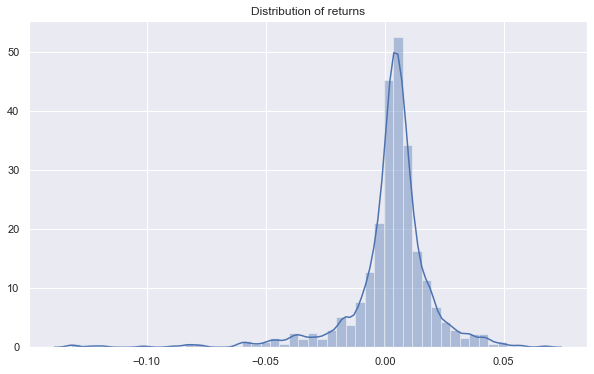

In [14]:
plt.figure(figsize=(10,6))
sns.distplot(rets)
plt.title('Distribution of returns')
plt.show()

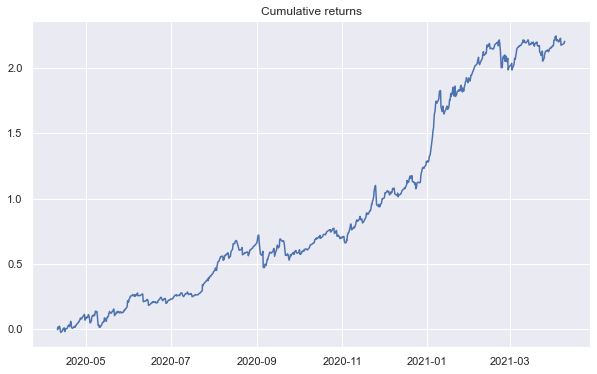

In [15]:
plt.figure(figsize=(10,6))
plt.plot(rets.cumsum())
plt.title('Cumulative returns')
plt.show()

In [16]:
SR = rets.mean()/rets.std()
print('Total Sharpe Ratio: ',SR)

Total Sharpe Ratio:  0.1270257859541224
